In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/kaggle-titanic/

/content/drive/My Drive/kaggle-titanic


In [ ]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=afcf23800c27b07c3996afb55a08c86971f0b03159c18d2075555ba67ed07dc7
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
import numpy as np
import pandas as pd
import os
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import keras.layers as L
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


time: 2.46 s


In [ ]:
train_df = pd.read_csv("train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


time: 295 ms


In [ ]:
test_df = pd.read_csv("test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


time: 168 ms


In [ ]:
def get_embarked(embarked):
  if embarked == "S":
    result = 1
  elif embarked == "C":
    result = 2
  elif embarked == "Q":
    result = 3
  else:
    result = 0
  return result 

def get_sex(sex):
  if sex == "male":
    result = 0
  elif sex == "female":
    result = 1
  else:
    result = 2
  return result

def replace_nan_to_zero(data):
  if math.isnan(data):
    data = 0
  return data

def get_class(prob):
  if prob[0] >= 0.5:
    result = 1
  else:
    result = 0
  return result


time: 9.6 ms


In [ ]:
y_train = train_df["Survived"]

train_df = train_df.drop(['Survived','Name','Ticket','Cabin'],axis=1)

train_df['Embarked'] = train_df['Embarked'].apply(get_embarked)

train_df['Sex'] = train_df['Sex'].apply(get_sex)

train_df.head()


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,0,22.0,1,0,7.2500,1
1,2,1,1,38.0,1,0,71.2833,2
2,3,3,1,26.0,0,0,7.9250,1
3,4,1,1,35.0,1,0,53.1000,1
4,5,3,0,35.0,0,0,8.0500,1


time: 26.6 ms


In [ ]:
test_df = test_df.drop(['Name','Ticket','Cabin'],axis=1)

test_df['Embarked'] = test_df['Embarked'].apply(get_embarked)

test_df['Sex'] = test_df['Sex'].apply(get_sex)

test_df['Age'] = test_df['Age'].apply(replace_nan_to_zero)

test_df['Fare'] = test_df['Fare'].apply(replace_nan_to_zero)

test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,3
1,893,3,1,47.0,1,0,7.0000,1
2,894,2,0,62.0,0,0,9.6875,3
3,895,3,0,27.0,0,0,8.6625,1
4,896,3,1,22.0,1,1,12.2875,1


time: 29.9 ms


In [ ]:
print(train_df.shape)
print(train_df.isnull().sum())
print(y_train.shape)


train_df['Age'] = train_df['Age'].apply(replace_nan_to_zero)
print(train_df.shape)
print(train_df.isnull().sum())
print(y_train.shape)

train_df.head()

(891, 8)
PassengerId      0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64
(891,)
(891, 8)
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
(891,)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,0,22.0,1,0,7.2500,1
1,2,1,1,38.0,1,0,71.2833,2
2,3,3,1,26.0,0,0,7.9250,1
3,4,1,1,35.0,1,0,53.1000,1
4,5,3,0,35.0,0,0,8.0500,1


time: 30.9 ms


In [ ]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch",'Fare','Embarked']

X_train = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])

print(X_train.head())
print(y_train.head())
print(X_test.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    0  22.0      1      0   7.2500         1
1       1    1  38.0      1      0  71.2833         2
2       3    1  26.0      0      0   7.9250         1
3       1    1  35.0      1      0  53.1000         1
4       3    0  35.0      0      0   8.0500         1
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    0  34.5      0      0   7.8292         3
1       3    1  47.0      1      0   7.0000         1
2       2    0  62.0      0      0   9.6875         3
3       3    0  27.0      0      0   8.6625         1
4       3    1  22.0      1      1  12.2875         1
time: 44.6 ms


In [ ]:
# param_grid = {'max_depth': [2,4,6,8,10,None], 'n_estimators': [10,50,100,300], 'criterion': ['gini','entropy']}

# rf_class = RandomForestClassifier(max_features='auto', random_state=44)

# grid_rf_class = GridSearchCV(estimator = rf_class, param_grid = param_grid, scoring='accuracy', n_jobs = 10, cv = 10, refit=True, return_train_score=True)

# grid_rf_class.fit(X_train, y_train)

# prediction = grid_rf_class.predict(X_test)

time: 2.24 ms


In [ ]:
# model = RandomForestClassifier(n_estimators=1000, max_depth=7, max_features='auto', random_state=44)
# model.fit(X_train,y_train)
# predictions = model.predict(X_test)

time: 956 µs


In [ ]:
print(X_train.shape)

(891, 7)
time: 1.49 ms


In [ ]:
def my_model(input_shape,learning_rate = 0.00001):

  model_input = L.Input(input_shape)
  x = L.Dense(100, activation='relu')(model_input)
  x = L.Dense(20, activation='relu')(x)
  x = L.Dense(10, activation='relu')(x)
  y = L.Dense(1,activation='sigmoid')(x)

  model = Model(inputs=model_input, outputs= y)

  optimizer = Adam(learning_rate=learning_rate)

  model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics='accuracy')

  return model


time: 4.74 ms


In [ ]:
model = my_model(input_shape = 7)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               800       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 3,041
Trainable params: 3,041
Non-trainable params: 0
_________________________________________________________________
time: 52.1 ms


In [ ]:
model_checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train,y_train,batch_size=32,epochs=2000,validation_split=0.2, callbacks=[model_checkpoint])



Streaming output truncated to the last 5000 lines.
Epoch 00751: val_loss did not improve from 0.40448
23/23 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.8596 - val_loss: 0.4116 - val_accuracy: 0.8324
Epoch 752/2000
 1/23 [>.............................] - ETA: 0s - loss: 0.3088 - accuracy: 0.8125
Epoch 00752: val_loss did not improve from 0.40448
23/23 [==============================] - 0s 2ms/step - loss: 0.3374 - accuracy: 0.8553 - val_loss: 0.4117 - val_accuracy: 0.8324
Epoch 753/2000
 1/23 [>.............................] - ETA: 0s - loss: 0.3817 - accuracy: 0.8750
Epoch 00753: val_loss did not improve from 0.40448
23/23 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.8610 - val_loss: 0.4123 - val_accuracy: 0.8324
Epoch 754/2000
 1/23 [>.............................] - ETA: 0s - loss: 0.1946 - accuracy: 0.9375
Epoch 00754: val_loss did not improve from 0.40448
23/23 [==============================] - 0s 3ms/step - loss: 0.3

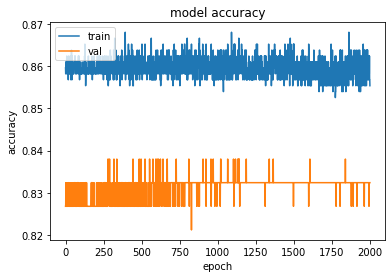

time: 184 ms


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

time: 2.8 ms


In [ ]:
prediction = model.predict(X_test).tolist()
prediction = pd.Series(prediction)
print(prediction[:5])
prediction = prediction.apply(get_class)
print(prediction[:5])

0      [0.0835961401462555]
1     [0.16089212894439697]
2    [0.025594234466552734]
3     [0.11230170726776123]
4      [0.4289948344230652]
dtype: object
0    0
1    0
2    0
3    0
4    0
dtype: int64
time: 70 ms


In [ ]:
# print(prediction.shape)
print(prediction)

0      0
1      0
2      0
3      0
4      0
      ..
413    0
414    1
415    0
416    0
417    1
Length: 418, dtype: int64
time: 2.24 ms


In [ ]:
output = pd.DataFrame({'PassengerId':test_df.PassengerId, 'Survived': prediction})

output.to_csv('my_submission.csv', index=False)
print(output.head())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
time: 15.5 ms
